# Michelin Rated Restaurants in France - Analysis

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from functions_visualisation import plot_choropleth, plot_multi_choropleth
from functions_analysis import plot_high_correlations, print_overview_stats, \
                                find_extreme_departments, plot_side_by_side

----
## We load in the departmental GeoJSON data

In [3]:
# Load GeoJSON departmental data
departments = gpd.read_file("../../data/France/department_restaurants.geojson")
print(departments.columns.tolist())

['code', 'department', 'capital', 'region', 'bib_gourmand', '1_star', '2_star', '3_star', 'total_stars', 'starred_restaurants', 'poverty_rate(%)', 'average_annual_unemployment_rate(%)', 'average_net_hourly_wage(€)', 'municipal_population', 'population_density(inhabitants/sq_km)', 'area(sq_km)', 'locations', 'geometry']


In [4]:
# For pair plots we remove the individual 'star' counts and drop the location data
dept_short = departments.drop(columns=['bib_gourmand', '1_star', '2_star', '3_star', 'locations', 'geometry'])

In [5]:
dept_short.head(3)

,code,department,capital,region,total_stars,starred_restaurants,poverty_rate(%),average_annual_unemployment_rate(%),average_net_hourly_wage(€),municipal_population,population_density(inhabitants/sq_km),area(sq_km)
0,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,7,5,10.5,5.5,15.34,657856.0,114.2,5760.56
1,02,Aisne,Laon,Hauts-de-France,0,0,18.0,10.5,13.92,529374.0,71.9,7362.64
2,03,Allier,Moulins,Auvergne-Rhône-Alpes,2,2,15.3,7.7,13.63,335628.0,45.7,7344.16


----
&nbsp;
# Analysis at Regional Level

Focus on mainland France and therefore Corsica is dropped

In [6]:
regions = dept_short.region.unique().tolist()
regions.remove("Corse")
print(f"Unique Regions:\n{regions}")

Unique Regions:
['Auvergne-Rhône-Alpes', 'Hauts-de-France', "Provence-Alpes-Côte d'Azur", 'Grand Est', 'Occitanie', 'Normandie', 'Nouvelle-Aquitaine', 'Centre-Val de Loire', 'Bourgogne-Franche-Comté', 'Bretagne', 'Pays de la Loire', 'Île-de-France']


In [7]:
print(dept_short.columns.tolist())

['code', 'department', 'capital', 'region', 'total_stars', 'starred_restaurants', 'poverty_rate(%)', 'average_annual_unemployment_rate(%)', 'average_net_hourly_wage(€)', 'municipal_population', 'population_density(inhabitants/sq_km)', 'area(sq_km)']


In [8]:
column_dictionary = {'total_stars': 'stars',
                    'starred_restaurants': 'starred_restos',
                    'poverty_rate(%)': 'poverty_rate',
                    'average_annual_unemployment_rate(%)': 'unemployment_rate',
                    'average_net_hourly_wage(€)': 'net_wage',
                    'municipal_population': 'population',
                    'population_density(inhabitants/sq_km)': 'pop_density',
                    'area(sq_km)': 'area'
                    }

In [9]:
# Renaming columns for clarity and concise visualization purposes.
dept_short.rename(columns=column_dictionary, inplace=True)
departments.rename(columns=column_dictionary, inplace=True)

----
&nbsp;
## Partition data into Northern/Southern France

In [10]:
south = dept_short[dept_short['region'].isin(["Provence-Alpes-Côte d'Azur", 'Occitanie',
                                              'Nouvelle-Aquitaine', 'Auvergne-Rhône-Alpes'])]

In [13]:
# Finding northern regions
s_regions = set(south.region.unique().tolist())
all_regions = set(regions)
n_regions = list(all_regions - s_regions)
print(n_regions)

['Centre-Val de Loire', 'Normandie', 'Grand Est', 'Bourgogne-Franche-Comté', 'Pays de la Loire', 'Île-de-France', 'Hauts-de-France', 'Bretagne']


In [14]:
# We exclude Paris
no_paris = dept_short[dept_short['department'] != 'Paris']

In [15]:
north = dept_short[dept_short['region'].isin(n_regions)]
north_no_paris = no_paris[no_paris['region'].isin(n_regions)]

`north` & `north_no_paris` are useful DataFrames for further analysis

----
&nbsp;
## Narrowing scope to Southern France

#### Pair Plots

We seek an overview of relationships between multiple variables

Departments: 43


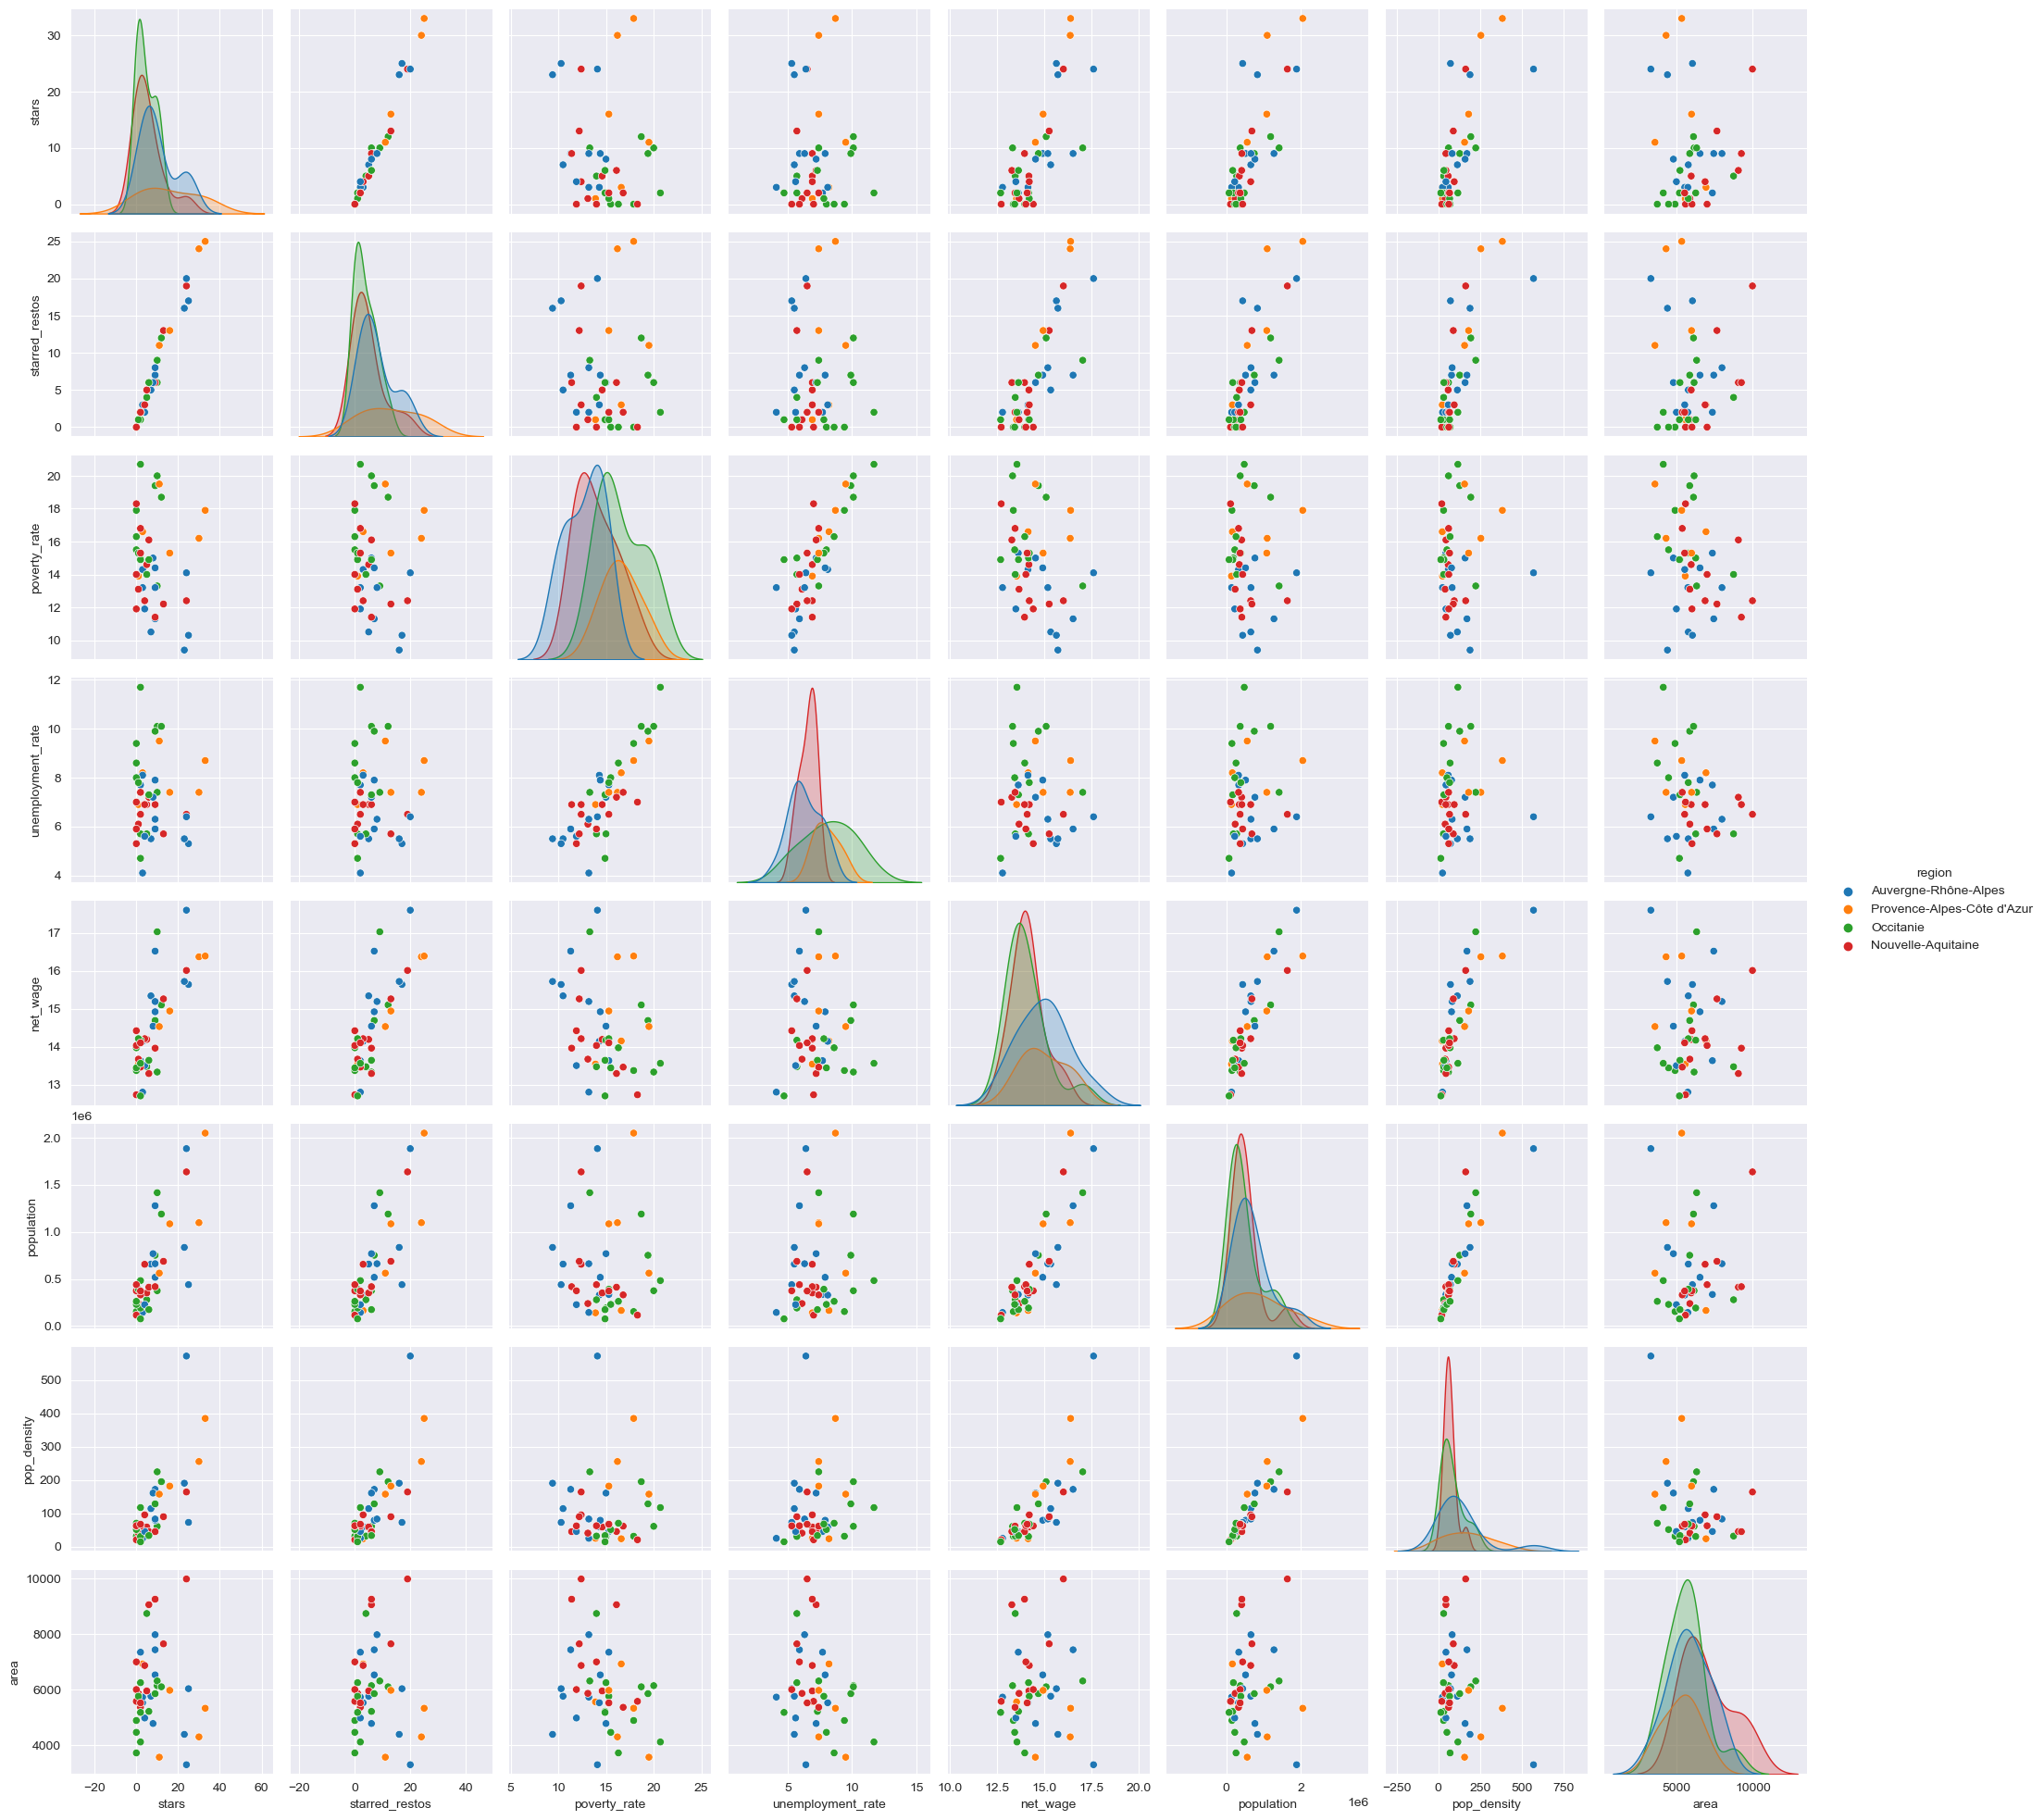

In [16]:
print(f"Departments: {south.department.nunique()}")
sns.pairplot(south, hue='region')

Based on the pair plot:

- *Auvergne-Rhône-Alpes* and *Provence-Alpes-Côte d'Azur* regions are prominently represented by five to six departments. These departments notably cluster towards the upper end in variables such as `total_stars` and `starred_restaurants` across most variable distributions.
&nbsp;
- In contrast, departments from the *Occitanie* region tend to cluster towards the lower spectrum, particularly for `total_stars`. Additionally, this region features prominently on the higher end of the `poverty_rate` and `unemployment_rate` scales. It's imperative to note, though, that while these patterns are evident, pinpointing whether the same departments persistently appear in these clusters across all variables would require a closer examination.
&nbsp;
- *Provence-Alpes-Côte d'Azur* stands out with the broadest spread in individual variable distributions, indicating a diverse range of values within this region.

While these patterns provide valuable insights, a deeper validation at the regional level is essential to confirm these preliminary findings.

#### Heatmaps

Visualising pairwise correlations above/below a certain threshold

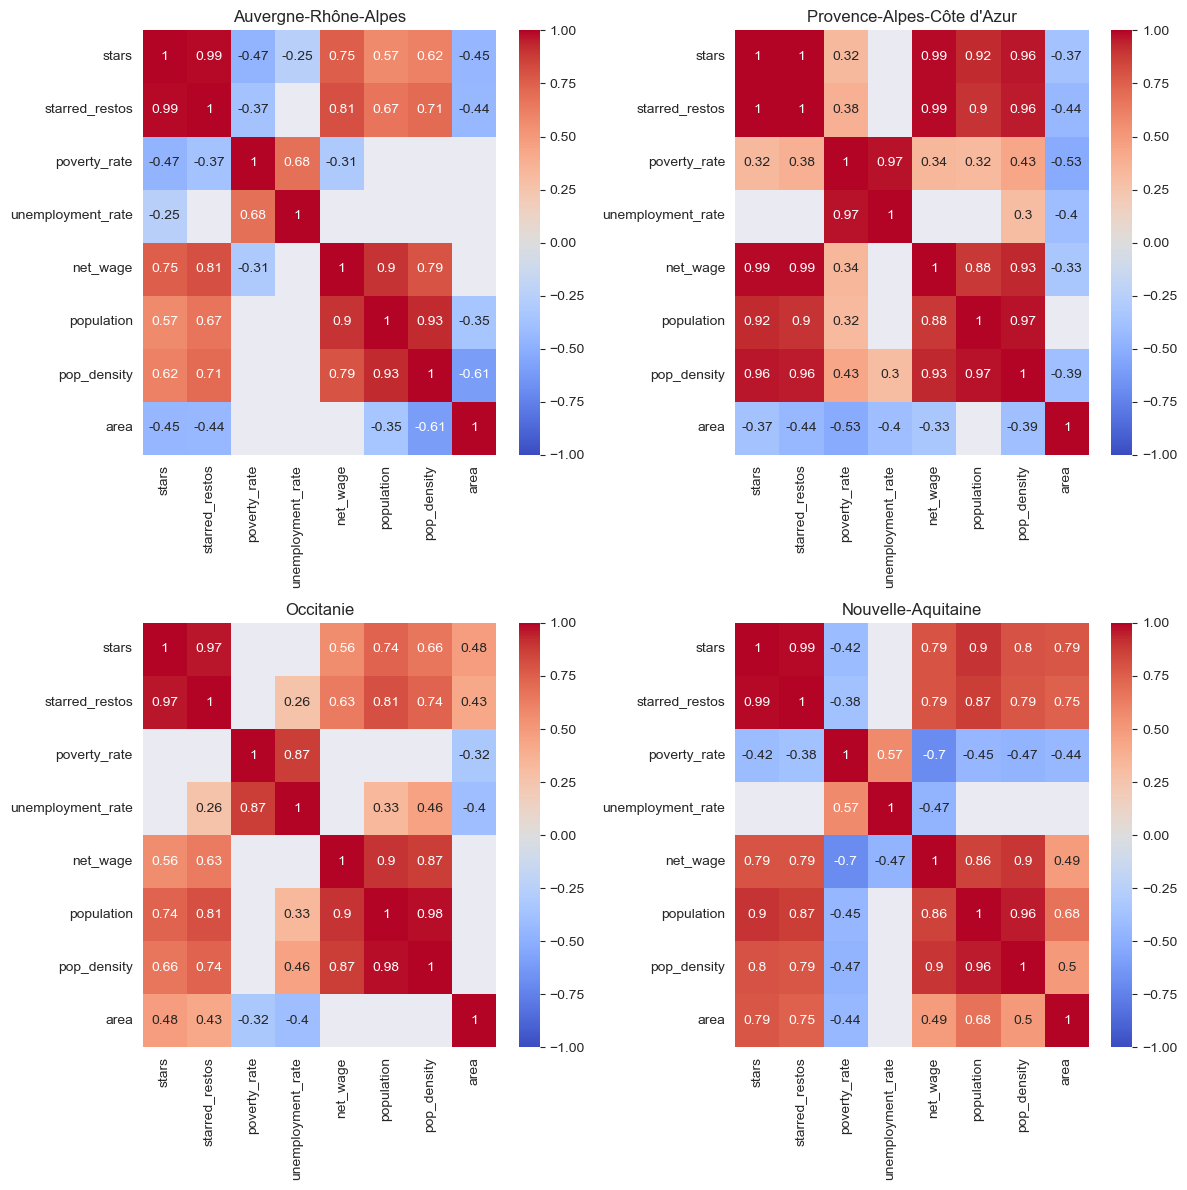

In [17]:
# We plot the correlation coefficients above a certain threshold
plot_high_correlations(south, level='regional', threshold=0.25)

It's difficult to infer pairwise correlations at the regional level

#### We will investigate `population_density`, `poverty_rate`, `unemployment_rate` & `net_wage` at the departmental level across regions.

We will also investigate the distribution of Michelin Stars

In [18]:
print(south.columns.tolist())

['code', 'department', 'capital', 'region', 'stars', 'starred_restos', 'poverty_rate', 'unemployment_rate', 'net_wage', 'population', 'pop_density', 'area']


We generate a statistical summary for selected columns, grouped by region, in the `south` dataframe.

In [19]:
cols_of_interest = ['starred_restos', 'poverty_rate', 'unemployment_rate', 'net_wage', 'pop_density']
overview = south.groupby('region')[cols_of_interest].describe()

In [20]:
print_overview_stats(overview)

Region: Auvergne-Rhône-Alpes
----------------------------
Statistic | Starred_restos | Poverty_rate | Unemployment_rate | Net_wage | Pop_density
--------------------------------------------------------------------------------------
Count     | 12.00          | 12.00        | 12.00             | 12.00    | 12.00      
Mean      | 7.92           | 12.74        | 6.29              | 14.96    | 134.99     
Std       | 6.30           | 2.00         | 1.22              | 1.35     | 147.47     
Min       | 2.00           | 9.40         | 4.10              | 12.80    | 25.20      
25%       | 2.75           | 11.10        | 5.50              | 14.01    | 56.12      
50%       | 6.50           | 13.20        | 6.10              | 15.05    | 81.15      
75%       | 10.00          | 14.33        | 7.33              | 15.66    | 163.58     
Max       | 20.00          | 15.30        | 8.10              | 17.60    | 571.30     
Region: Nouvelle-Aquitaine
--------------------------
Statistic | Starre

We find the min/max department within each region for each column of interest

In [21]:
find_extreme_departments(south, cols_of_interest)

Region: Auvergne-Rhône-Alpes

starred_restos
	Max: Rhône (69) = 20 
	Min: Allier (03) = 2 

poverty_rate
	Max: Allier (03) = 15.3 %
	Min: Haute-Savoie (74) = 9.4 %

unemployment_rate
	Max: Ardèche (07) = 8.1 %
	Min: Cantal (15) = 4.1 %

net_wage
	Max: Rhône (69) = 17.6 €
	Min: Cantal (15) = 12.8 €

pop_density
	Max: Rhône (69) = 571.3 inhabitants/sq_km
	Min: Cantal (15) = 25.2 inhabitants/sq_km

--------------------------------------------------
Region: Provence-Alpes-Côte d'Azur

starred_restos
	Max: Bouches-du-Rhône (13) = 25 
	Min: Hautes-Alpes (05) = 1 

poverty_rate
	Max: Vaucluse (84) = 19.5 %
	Min: Hautes-Alpes (05) = 13.9 %

unemployment_rate
	Max: Vaucluse (84) = 9.5 %
	Min: Hautes-Alpes (05) = 6.9 %

net_wage
	Max: Bouches-du-Rhône (13) = 16.39 €
	Min: Hautes-Alpes (05) = 13.54 €

pop_density
	Max: Bouches-du-Rhône (13) = 384.4 inhabitants/sq_km
	Min: Alpes-de-Haute-Provence (04) = 23.9 inhabitants/sq_km

--------------------------------------------------
Region: Occitanie

s

To better understand these results, we find the weighted mean `poverty_rate`, `unemployment_rate` and `net_wage` across France
$$
\mathrm{Weighted \ Mean} = \frac{\sum_i (\mathrm{value}_i \times \mathrm{weight}_i)}{\sum_i \mathrm{weight}_i}
$$

In [22]:
print(south.columns.tolist())

['code', 'department', 'capital', 'region', 'stars', 'starred_restos', 'poverty_rate', 'unemployment_rate', 'net_wage', 'population', 'pop_density', 'area']


In [23]:
# Compute the weighted means
france_poverty = (departments['poverty_rate'] * departments['population']).sum() /\
                        departments['population'].sum()

france_unemployment = (departments['unemployment_rate'] * departments['population']).sum() /\
                        departments['population'].sum()

france_wage = (departments['net_wage'] * departments['population']).sum() /\
                        departments['population'].sum()

print(f"Weighted mean poverty rate across France: {france_poverty:.2f}%")
print(f"Weighted mean unemployment rate across France: {france_unemployment:.2f}%")
print(f"Weighted mean hourly wage across France: {france_wage:.2f}€")

Weighted mean poverty rate across France: 14.43%
Weighted mean unemployment rate across France: 7.13%
Weighted mean hourly wage across France: 16.05€


Average Hourly wage gives insights into earning potential and can hint at the type of prevalent industries in an area

A high poverty rate could indicate economic distress, lack of job opportunities, or other socioeconomic challenges.

Unemployment rate is a direct indicator of job market health. A higher rate can signify economic downturns, structural challenges in the economy, or mismatch of skills in the job market.

Examining departmental extrema, we notice *Pyrénées-Orientales* (66) in Occitanie and *Vaucluse* (84) in PACA have poverty and unemployment rates well above the national average.

----
&nbsp;
## Narrowing scope to *Provence-Alpes-Côte d'Azur* & *Occitanie*

#### We use the GeoDataFrame `departments` to create choropleth maps

In [24]:
print(departments.columns.tolist())

['code', 'department', 'capital', 'region', 'bib_gourmand', '1_star', '2_star', '3_star', 'stars', 'starred_restos', 'poverty_rate', 'unemployment_rate', 'net_wage', 'population', 'pop_density', 'area', 'locations', 'geometry']


----
&nbsp;
### Provence-Alpes-Côte d'Azur

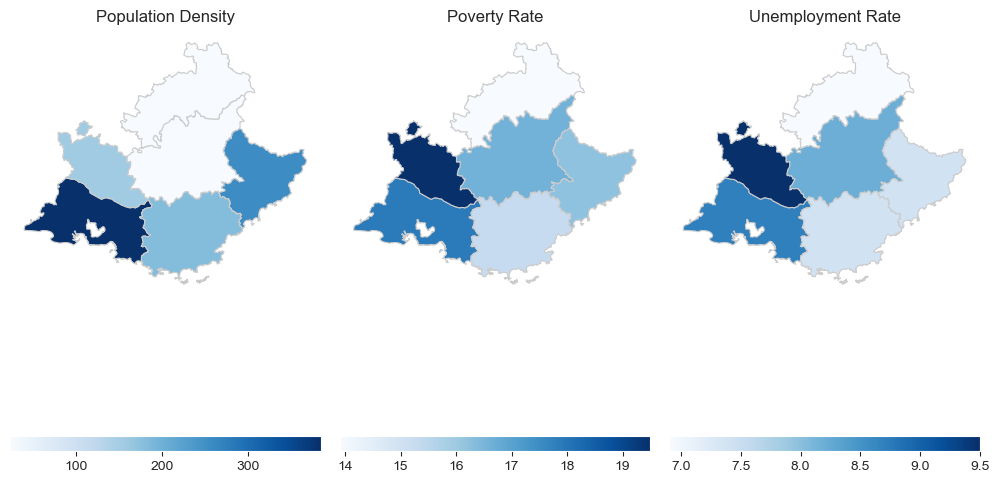

In [25]:
paca = departments[departments['region'] == "Provence-Alpes-Côte d'Azur"]
plot_multi_choropleth(paca, ['pop_density', 'poverty_rate', 'unemployment_rate'],
                          ['Population Density', 'Poverty Rate', 'Unemployment Rate'])

In [26]:
cols_of_interest = ['poverty_rate', 'unemployment_rate', 'net_wage', 'pop_density']
french_means = {'poverty': france_poverty,
                'unemployment': france_unemployment,
                'wage': france_wage}

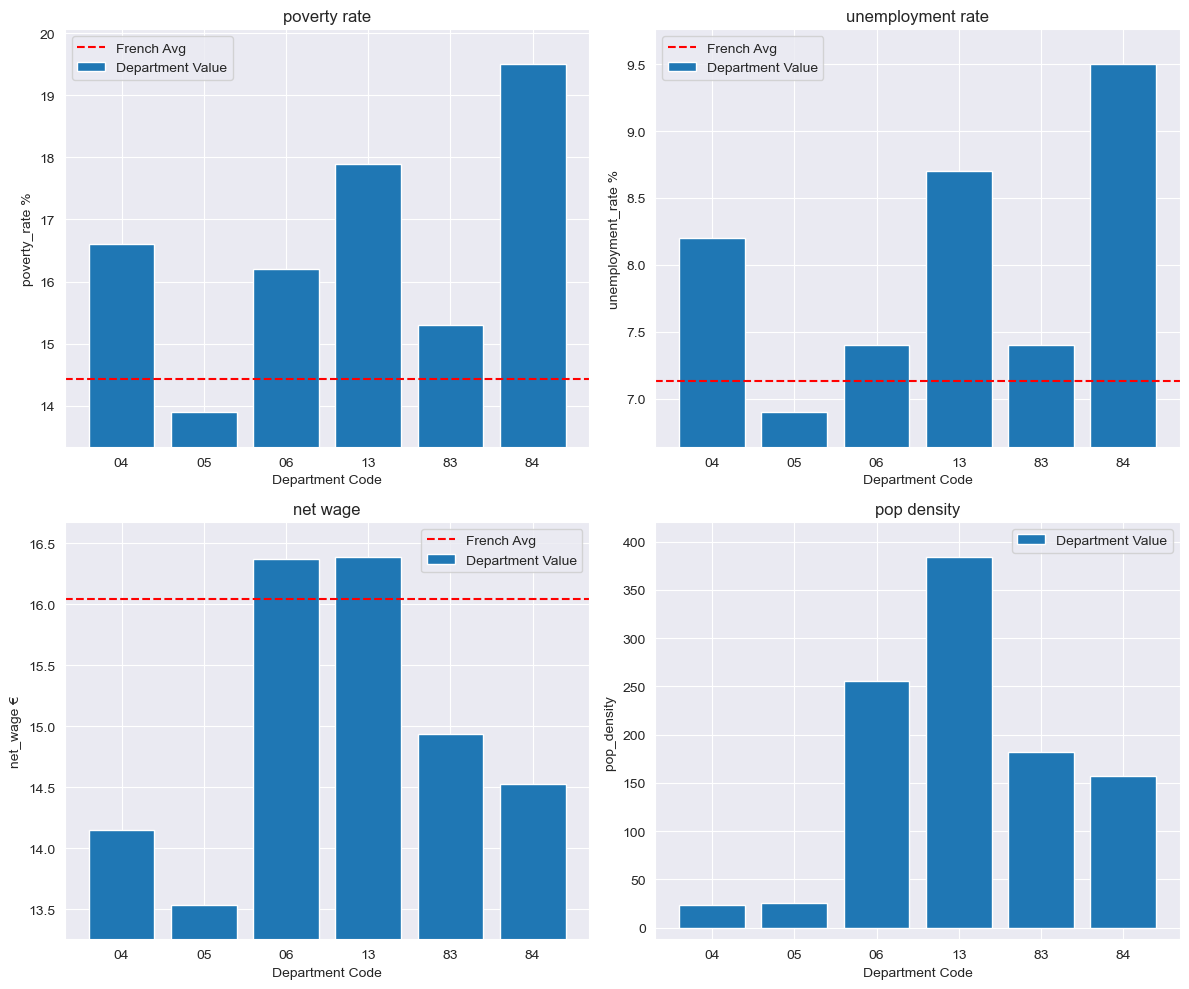

In [27]:
plot_side_by_side(paca, cols_of_interest, french_means)

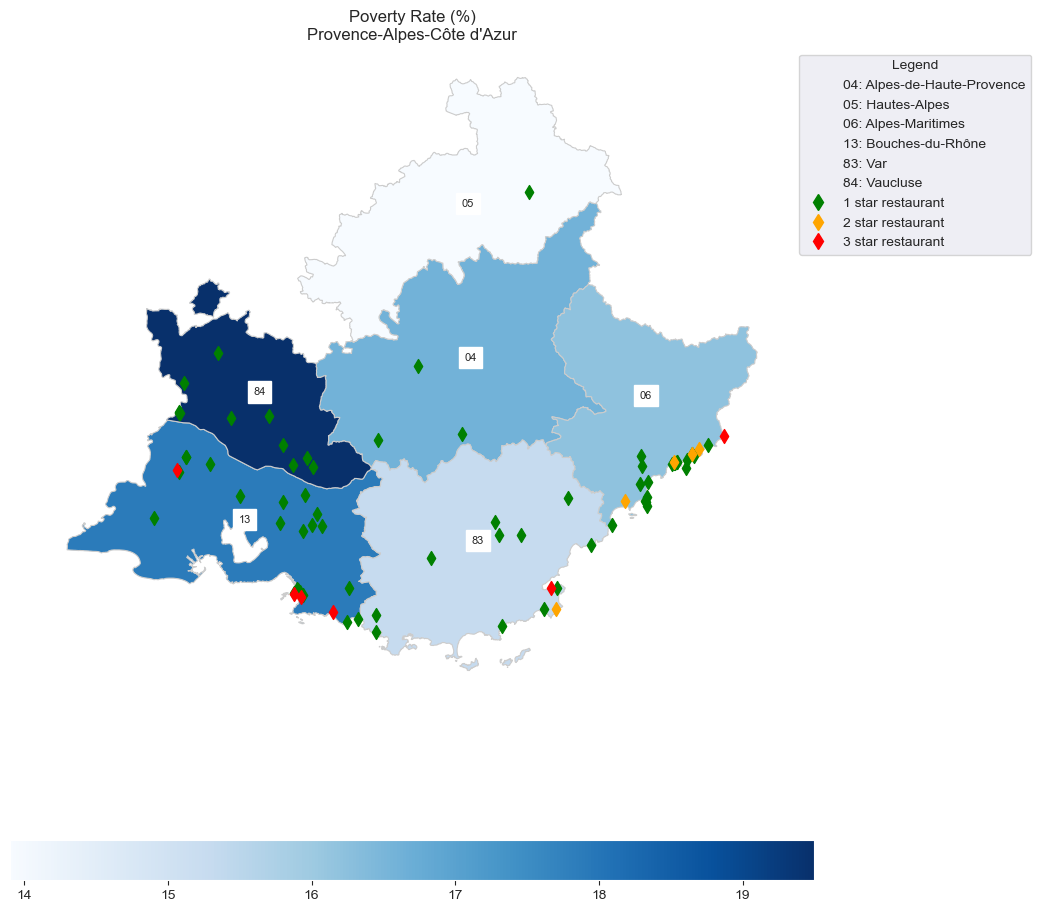

In [28]:
plot_choropleth(paca, 'poverty_rate', 'Poverty Rate (%)', restaurants=True, regional=True)

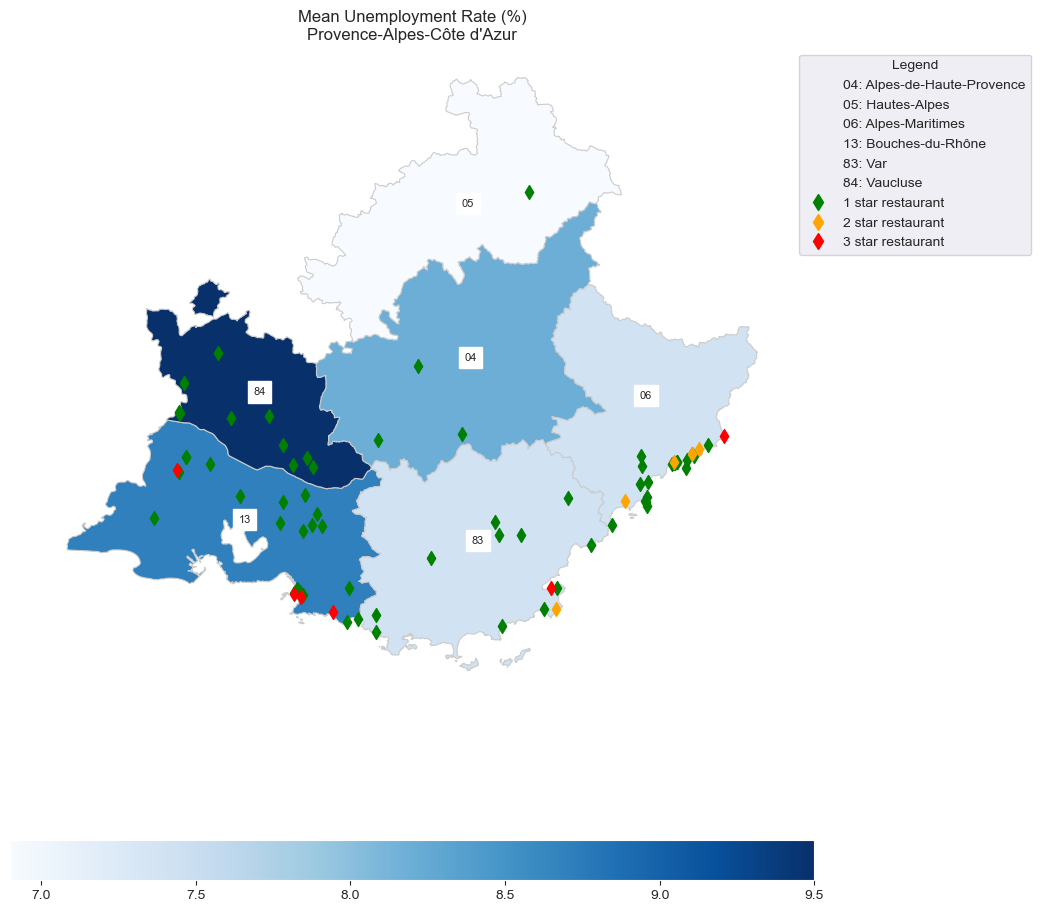

In [29]:
plot_choropleth(paca, 'unemployment_rate', 'Mean Unemployment Rate (%)', restaurants=True, regional=True)

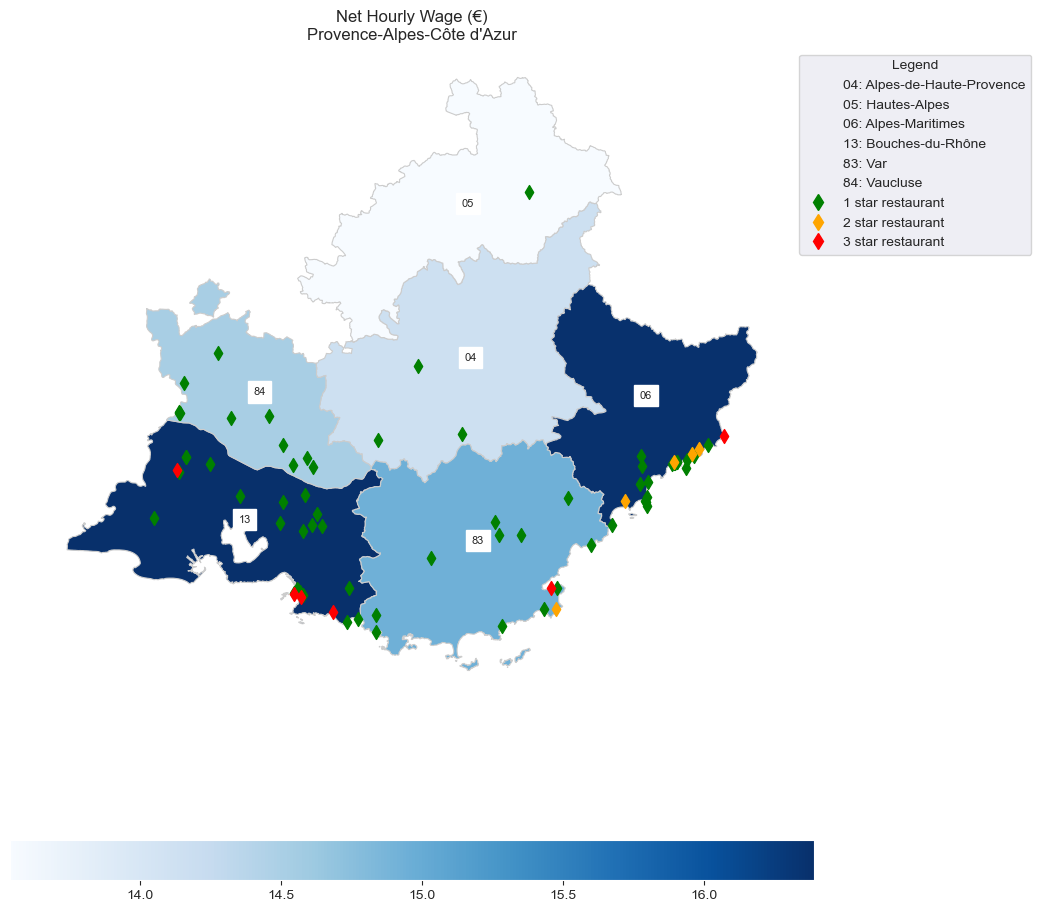

In [30]:
plot_choropleth(paca, 'net_wage', 'Net Hourly Wage (€)', restaurants=True, regional=True)

----
&nbsp;
### Occitanie

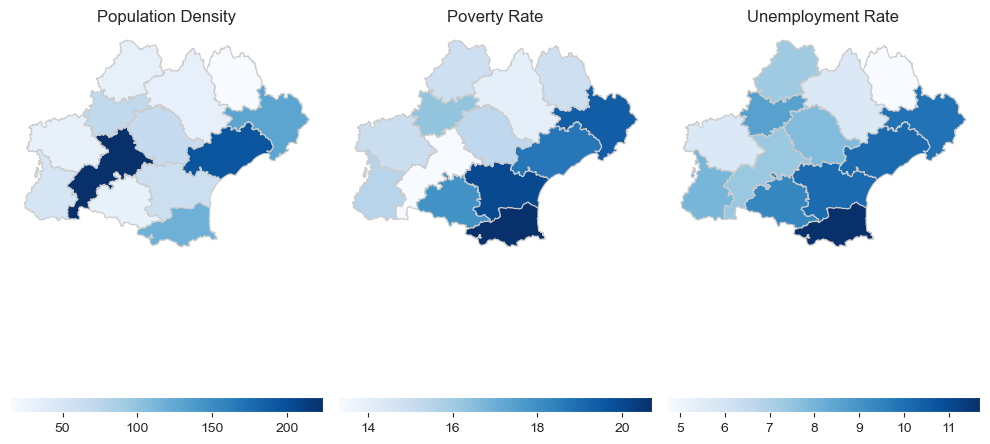

In [31]:
occitanie = departments[departments['region'] == "Occitanie"]
plot_multi_choropleth(occitanie, ['pop_density', 'poverty_rate', 'unemployment_rate'],
                          ['Population Density', 'Poverty Rate', 'Unemployment Rate'])

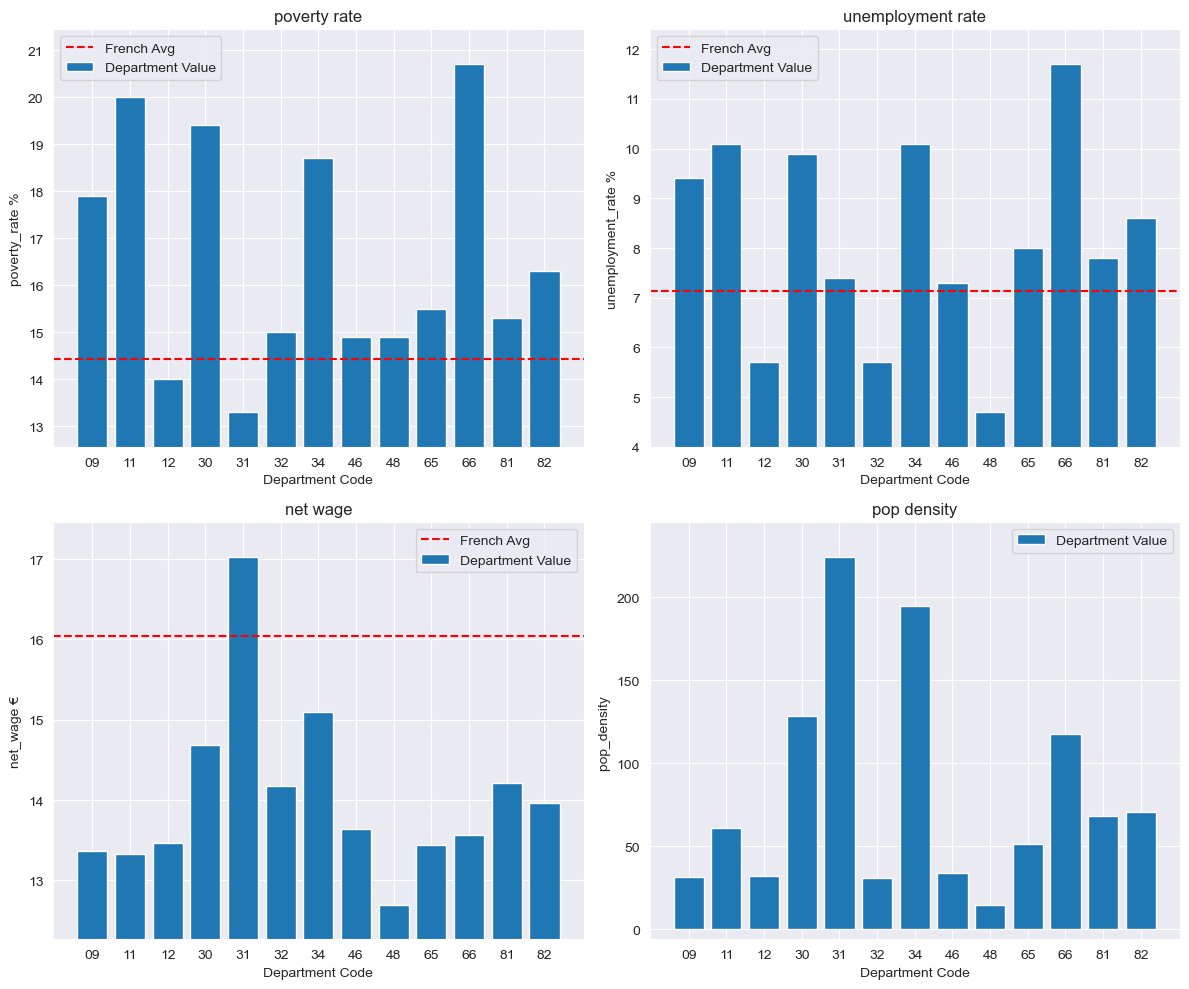

In [32]:
plot_side_by_side(occitanie, cols_of_interest, french_means)

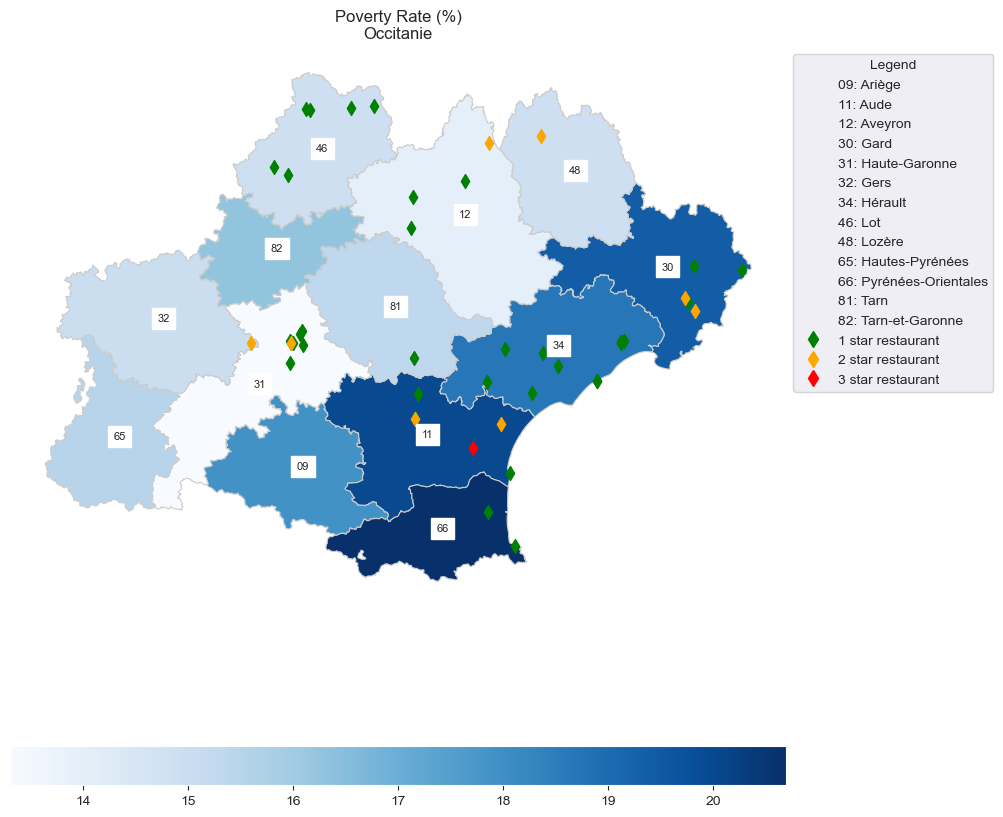

In [33]:
plot_choropleth(occitanie, 'poverty_rate', 'Poverty Rate (%)', restaurants=True, regional=True)

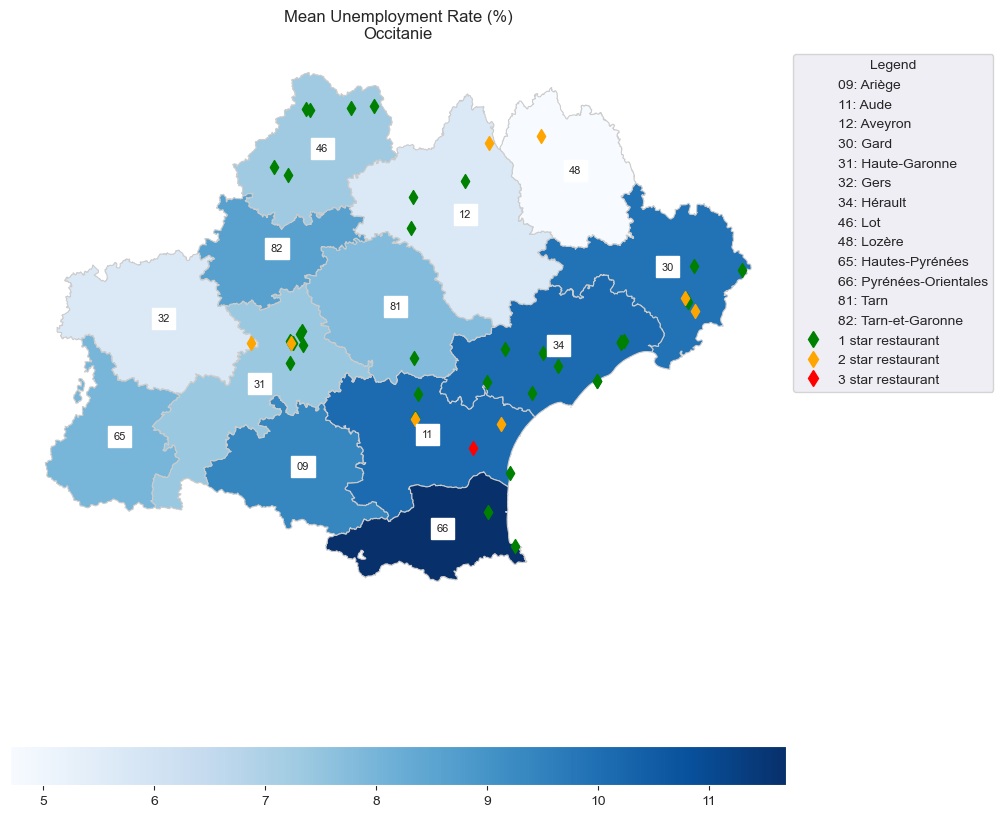

In [34]:
plot_choropleth(occitanie, 'unemployment_rate', 'Mean Unemployment Rate (%)', restaurants=True, regional=True)

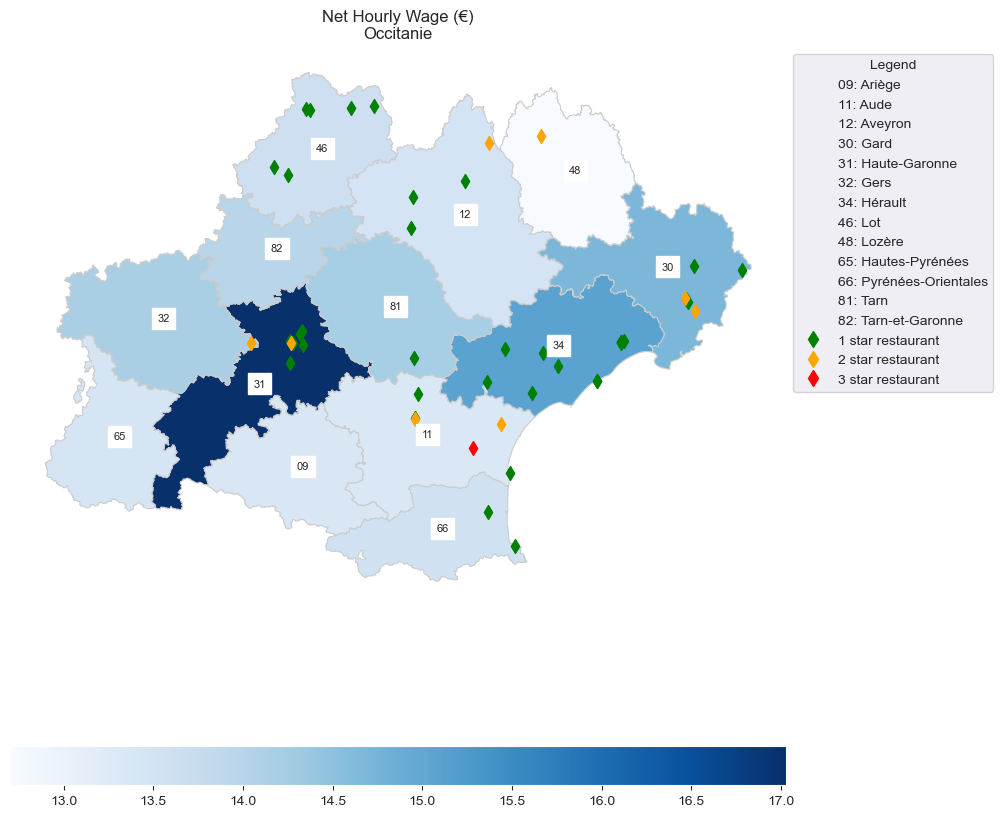

In [35]:
plot_choropleth(occitanie, 'net_wage', 'Net Hourly Wage (€)', restaurants=True, regional=True)